# Import Required Libraries
Import the necessary libraries, including matplotlib and seaborn.

In [12]:
# Import Required Libraries
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
# import geopandas as gpd
# from shapely.geometry import Point

In [3]:
import pandas as pd


In [6]:
df = pd.read_csv('spi_results.csv')
df.head()
stations = df[['station_name', 'station_id']].drop_duplicates()
print (stations)

           station_name  station_id
0               Ardebil       40708
412            Khalkhal       40717
824            Parsabad       40700
1236            Mahabad       40726
1648               Maku       40701
2060           Orumiyeh       40712
2472               Ahar       40704
2884              Sarab       40710
3296             Mianeh       40716
3708  Maragheh-synoptic       40713
4120             Tabriz       40706
4532       Meshkinshahr       40705
4881  Ardebil (Airport)       88107


,station_id,lat,lon,geometry
0,40708,38.219,48.329,POINT (48.329 38.219)
412,40717,37.609,48.538,POINT (48.538 37.609)
824,40700,39.608,47.877,POINT (47.877 39.608)
1236,40726,36.753,45.715,POINT (45.715 36.753)
1648,40701,39.379,44.392,POINT (44.392 39.379)
2060,40712,37.658,45.056,POINT (45.056 37.658)
2472,40704,38.433,47.067,POINT (47.067 38.433)
2884,40710,37.935,47.508,POINT (47.508 37.935)
3296,40716,37.421,47.732,POINT (47.732 37.421)
3708,40713,37.348,46.146,POINT (46.146 37.348)


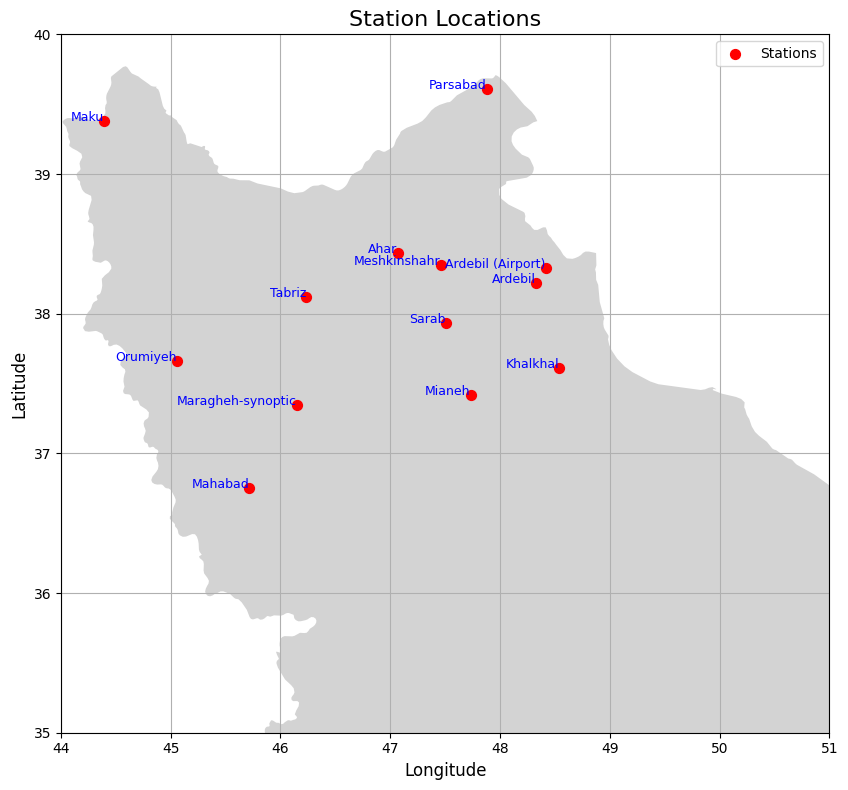

In [ ]:

world = gpd.read_file('ir_shp\ir.shp')

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
world.plot(ax=ax, color='lightgray')

# Extract unique station locations
stations = df[['station_name', 'lat', 'lon']].drop_duplicates()


# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(stations['lon'], stations['lat'])]
geo_df = gpd.GeoDataFrame(stations, geometry=geometry)

# Set Coordinate Reference System (CRS) to WGS84 (EPSG:4326)
geo_df.set_crs(epsg=4326, inplace=True)

# Add station points
geo_df.plot(ax=ax, color='red', markersize=50, label='Stations')

# Add labels for station IDs
for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df['station_name']):
    ax.text(x, y, str(label), fontsize=9, ha='right', color='blue')

xmin, xmax = 44, 51  # Adjust longitude range
ymin, ymax = 35, 40  # Adjust latitude range
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Customize the plot
plt.title('Station Locations', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend()
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()


C:\Users\Acer\AppData\Local\Temp\ipykernel_13432\110476579.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


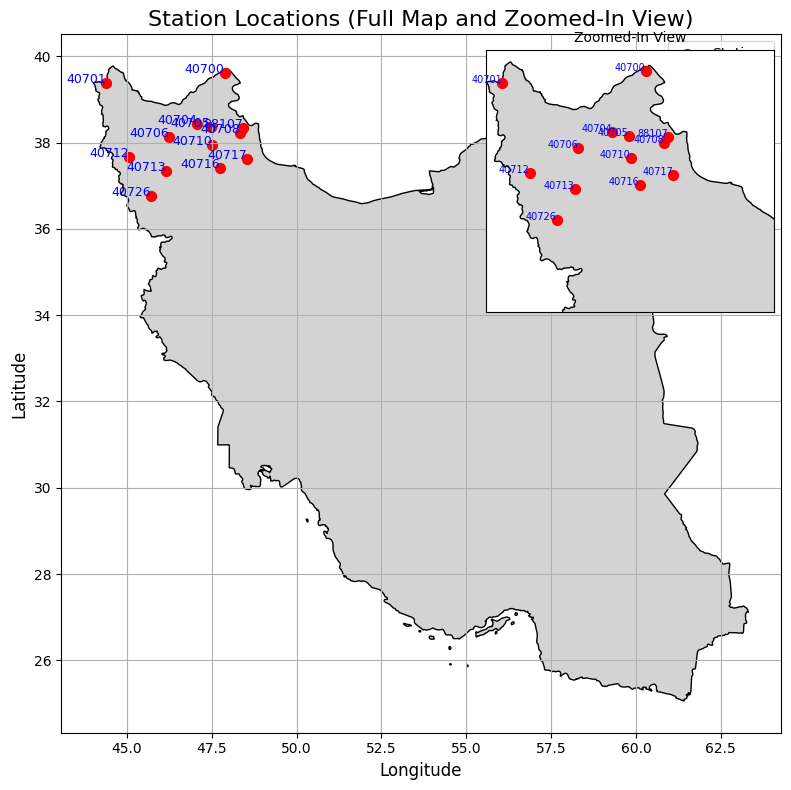

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Load Iran shapefile
world = gpd.read_file('ir_shp/ir.shp')


# Extract unique station locations
stations = df[['station_id', 'lat', 'lon']].drop_duplicates()

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(stations['lon'], stations['lat'])]
geo_df = gpd.GeoDataFrame(stations, geometry=geometry)

# Set Coordinate Reference System (CRS) to WGS84 (EPSG:4326)
geo_df.set_crs(epsg=4326, inplace=True)

# Plot the full map
fig, ax = plt.subplots(figsize=(12, 8))
world.plot(ax=ax, color='lightgray', edgecolor='black')
geo_df.plot(ax=ax, color='red', markersize=50, label='Stations')

# Add labels for station IDs
for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df['station_id']):
    ax.text(x, y, str(label), fontsize=9, ha='right', color='blue')

# Customize the main plot
plt.title('Station Locations (Full Map and Zoomed-In View)', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend()
plt.grid()

# Create an inset for the zoomed-in view
axins = inset_axes(ax, width="40%", height="40%", loc='upper right')  # Adjust size and location
world.plot(ax=axins, color='lightgray', edgecolor='black')
geo_df.plot(ax=axins, color='red', markersize=50)

# Add labels in the inset
for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df['station_id']):
    axins.text(x, y, str(label), fontsize=7, ha='right', color='blue')

# Set limits for the zoomed-in inset
xmin, xmax = 44, 51  # Adjust longitude range
ymin, ymax = 35, 40  # Adjust latitude range
axins.set_xlim(xmin, xmax)
axins.set_ylim(ymin, ymax)

# Remove gridlines and labels in the inset for a cleaner look
axins.set_xticks([])
axins.set_yticks([])
axins.set_title("Zoomed-In View", fontsize=10)

# Finalize and show the plot
plt.tight_layout()
plt.show()


In [1]:
print (stations)

NameError: name 'stations' is not defined

# Define Functions
Define the functions used in the code.

In [11]:
def plot_spi(station_id, spi_df):
    """
    Plot the Standardized Precipitation Index (SPI) for a specific station.
    
    Parameters:
    station_id (int): The ID of the station to plot.
    spi_df (DataFrame): DataFrame containing SPI values.
    """
    station_data = spi_df[spi_df['station_id'] == station_id]
    plt.figure(figsize=(10, 6))
    plt.plot(station_data['data'], station_data['SPI'], marker='o', linestyle='-')
    plt.title(f'SPI for Station {station_id}')
    plt.xlabel('Date')
    plt.ylabel('SPI')
    plt.grid(True)
    plt.show()

def plot_drought_heatmap(spi_df):
    """
    Plot a heatmap of drought conditions based on SPI values.
    
    Parameters:
    spi_df (DataFrame): DataFrame containing SPI values.
    """
    pivot_table = spi_df.pivot_table(index='data', columns='station_id', values='SPI')
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, cmap='RdYlBu_r', center=0, annot=False, cbar_kws={'label': 'SPI'})
    plt.title('Drought Conditions Heatmap')
    plt.xlabel('Station ID')
    plt.ylabel('Month')
    plt.show()

In [10]:
def plot_spi_6_month_avg(station_id, spi_df):
    """
    Plot the 6-month moving average of the Standardized Precipitation Index (SPI) for a specific station.
    
    Parameters:
    station_id (int): The ID of the station to plot.
    spi_df (DataFrame): DataFrame containing SPI values with a 'date' column.
    """
    # Filter data for the given station
    station_data = spi_df[spi_df['station_id'] == station_id].copy()
    
    # Ensure the 'date' column is a datetime object for proper sorting
    station_data['data'] = pd.to_datetime(station_data['data'])
    station_data.sort_values('data', inplace=True)
    
    # Calculate the 6-month moving average for SPI
    station_data['SPI_6_month_avg'] = station_data['SPI'].rolling(window=6, min_periods=1).mean()
    
    # Plot the 6-month moving average SPI
    plt.figure(figsize=(10, 6))
    plt.plot(station_data['data'], station_data['SPI_6_month_avg'], marker='o', linestyle='-', label='6-Month Average')
    plt.title(f'6-Month Average SPI for Station {station_id}')
    plt.xlabel('Data')
    plt.ylabel('SPI')
    plt.grid(True)
    plt.legend()
    plt.show()


/var/folders/l6/yrsyry2s2j9d9wsdpgw_c28r0000gn/T/ipykernel_4553/3636906346.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  station_data['data'] = pd.to_datetime(station_data['data'])


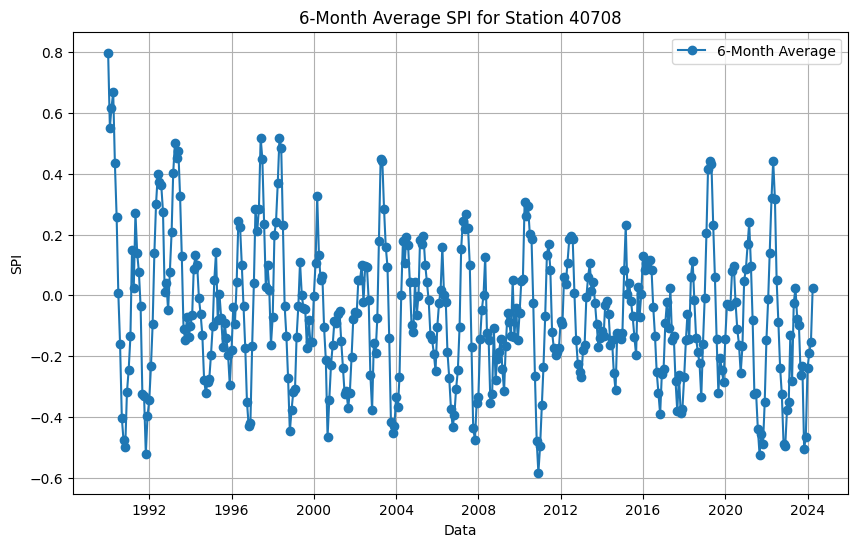

In [13]:

plot_spi_6_month_avg(station_id=40708, spi_df= df)

# plot_spi Function
Define the plot_spi function to plot SPI for a specific station.

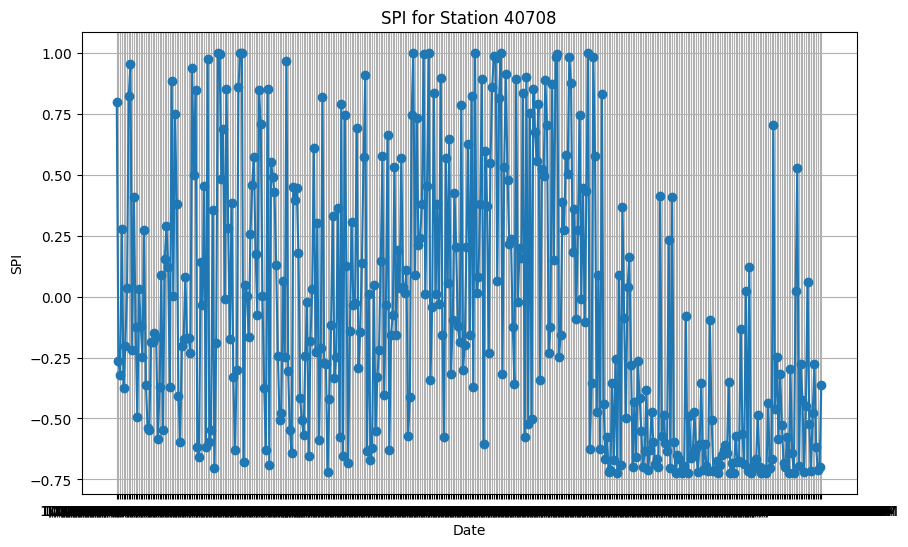

In [8]:
# Example: Plot SPI for a Specific Station
plot_spi(station_id=40708, spi_df=spi_df)

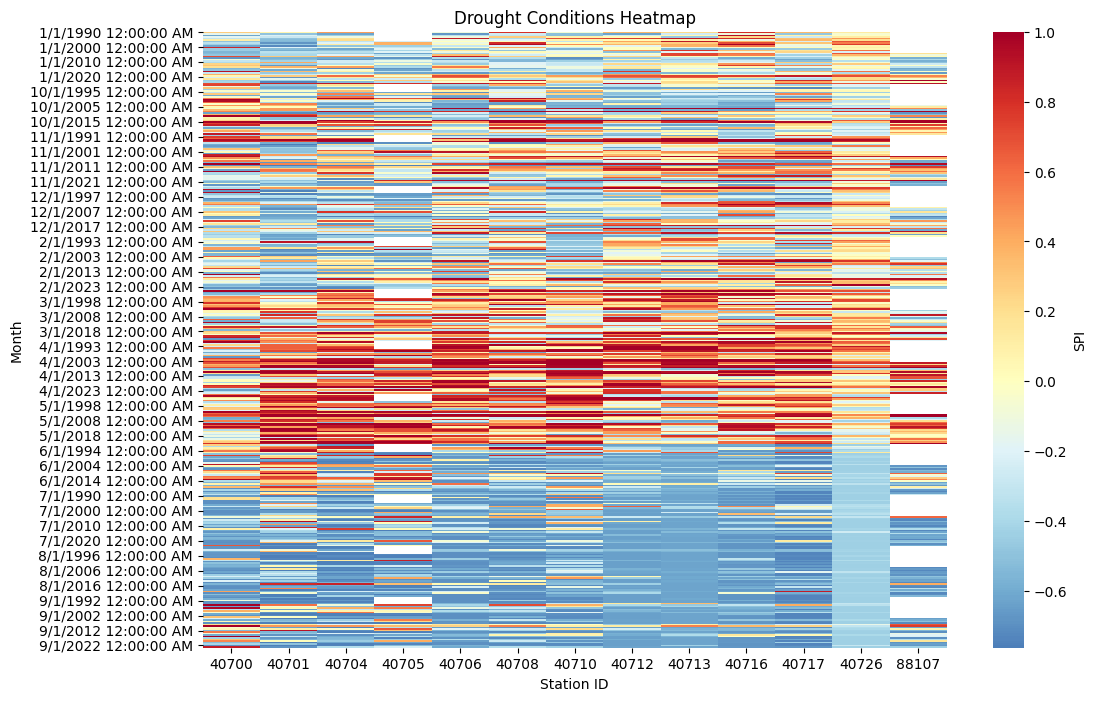

In [9]:
# Generate Heatmap
plot_drought_heatmap(spi_df)